In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [ ]:
# TODO 1.1: Загрузите датасет Reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data()

# TODO 1.2: Изучите структуру данных
print("Тип x_train:", type(x_train))
print("Длина x_train:", len(x_train))
print("Первая последовательность (первые 10 индексов):", x_train[0][:10])
print("Длина первой последовательности:", len(x_train[0]))

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Тип x_train: <class 'numpy.ndarray'>
Длина x_train: 8982
Первая последовательность (первые 10 индексов): [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207]
Длина первой последовательности: 87


In [ ]:
# TODO 2.1: Загрузите словарь слов
word_index = reuters.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
# TODO 2.2: Реализуйте функцию декодирования последовательности
def decode_sequence(sequence):
    return ' '.join([reverse_word_index.get(i-3, '?') for i in sequence])

first_article = decode_sequence(x_train[0])
print("\nПервая статья (первые 200 символов):", first_article[:200])


Первая статья (первые 200 символов): ? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net shou


In [ ]:
# TODO 3.1: Объедините первые 1000 статей в один текст
max_articles = 1000
max_articles_idx = x_train[:max_articles]
max_articles_texts = [decode_sequence(seq) for seq in max_articles_idx]
texts = ' '.join(max_articles_texts)

print(f"Общая длина текста (символов): {len(texts)}")
print("Пример текста:", texts[:500])

Общая длина текста (символов): 815340
Пример текста: ? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3 ? generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct 


In [ ]:
# TODO 3.2: Создайте словари для преобразования символов в индексы и обратно
chars = sorted(list(set(texts)))
print(chars)

[' ', "'", '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

vocab_size = len(chars)
print(f"Размер словаря (уникальных символов): {vocab_size}")

Размер словаря (уникальных символов): 39


In [ ]:
# TODO 3.3: Преобразуйте текст в последовательность индексов
text_as_int = [char_to_idx[ch] for ch in texts]
texts[:10], text_as_int[:10]

('? mcgrath ', [12, 0, 25, 15, 19, 30, 13, 32, 20, 0])

In [ ]:
text_as_int = np.array(text_as_int)

text_as_int

array([12,  0, 25, ..., 30,  0,  5])

In [ ]:
seq_length = 100

In [ ]:
# TODO 4.1: Реализуйте функцию create_sequences для создания обучающих примеров
def create_sequences(text_indices, seq_len):
    input_seq = []
    target_seq = []

    for i in range(len(text_indices)-seq_len):
        current_x_seq = text_indices[i:i+seq_len]
        input_seq.append(current_x_seq)

        current_y_seq = text_indices[i+seq_len]
        target_seq.append(current_y_seq)

    return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

input_seq, target_seq = create_sequences(text_as_int, seq_length)

/tmp/ipython-input-816/2203781802.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)


In [ ]:
# TODO 4.2: Создайте DataLoader для пакетной обработки
batch_size = 32
dataset = torch.utils.data.TensorDataset(input_seq, target_seq)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=2, embedding_dim=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # TODO 5.1: Определите слои модели
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # TODO 5.2: Реализуйте forward pass
        # Шаг 1: Примените слой эмбеддинга
        embedded = self.embedding(x)

        # Шаг 2: Прямой проход через LSTM
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)

        # Шаг 3: Возьмите только последний выход LSTM
        lstm_out = lstm_out[:, -1, :]

        # Шаг 4: Примените полносвязный слой
        output = self.fc(lstm_out)

        return output, hidden

device = torch.device('cuda')

In [ ]:
# Функция для генерации текста
def generate_text(model, seed_text, length=100, temperature=1.0):
    """Генерация текста на основе начальной последовательности."""
    model.eval()
    generated = seed_text

    # Преобразуем seed в индексы, фильтруя символы, которых нет в словаре
    seed_indices = []
    for ch in seed_text:
        if ch in char_to_idx:
            seed_indices.append(char_to_idx[ch])
        else:
            # Если символа нет в словаре, используем первый попавшийся символ
            seed_indices.append(0)

    if len(seed_indices) == 0:
        seed_indices = [0]  # На случай пустого seed

    with torch.no_grad():
        # Создаем начальное hidden state
        batch_size = 1
        h0 = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        c0 = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        hidden = (h0, c0)

        # "Прогреваем" модель на seed последовательности
        for i in range(len(seed_indices) - 1):
            input_tensor = torch.tensor([[seed_indices[i]]], dtype=torch.long).to(device)
            _, hidden = model(input_tensor, hidden)

        # Начинаем генерацию
        current_input = torch.tensor([[seed_indices[-1]]], dtype=torch.long).to(device)

        for _ in range(length):
            output, hidden = model(current_input, hidden)

            # Применяем temperature для управления случайностью
            output = output / temperature
            probabilities = torch.softmax(output, dim=-1)

            # Выбираем следующий символ на основе вероятностей
            next_char_idx = torch.multinomial(probabilities, 1).item()

            # Добавляем символ к сгенерированному тексту
            generated += idx_to_char[next_char_idx]

            # Обновляем вход для следующей итерации
            current_input = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return generated

6. ОБУЧЕНИЕ МОДЕЛИ

In [ ]:
EPOCHS = 4

# Функция потерь
criterion = nn.CrossEntropyLoss()

In [ ]:
# TODO 5.3: Инициализируйте модель
model_1 = CharLSTM(vocab_size=vocab_size, hidden_size=64, num_layers=1)
model_1 = model_1.to(device)
print(f"\nМодель:\n{model_1}")
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.01)

model_2 = CharLSTM(vocab_size=vocab_size, hidden_size=256, num_layers=2)
model_2 = model_2.to(device)
print(f"\nМодель:\n{model_2}")
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

model_3 = CharLSTM(vocab_size=vocab_size, hidden_size=128, num_layers=2)
model_3 = model_3.to(device)
print(f"\nМодель:\n{model_3}")
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.005)


Модель:
CharLSTM(
  (embedding): Embedding(39, 64)
  (lstm): LSTM(64, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=39, bias=True)
)

Модель:
CharLSTM(
  (embedding): Embedding(39, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=39, bias=True)
)

Модель:
CharLSTM(
  (embedding): Embedding(39, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=39, bias=True)
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


In [ ]:
def train_loop(model, optimizer):
    # Тренировочный цикл
    train_losses = []

    print("\nНачало обучения...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        batch_count = len(dataloader)

        for batch_idx, (batch_input, batch_target) in enumerate(dataloader):
            # Перемещаем данные на GPU
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            optimizer.zero_grad()

            # Прямой проход
            output, _ = model(batch_input)
            loss = criterion(output, batch_target)

            # Обратное распространение
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            # Логгирование прогресса каждые 50 батчей
            if (batch_idx + 1) % 50 == 0:
                avg_batch_loss = loss.item()
                print(f'Эпоха [{epoch+1}/{EPOCHS}], Батч [{batch_idx+1}/{batch_count}], Потеря: {avg_batch_loss:.4f}')

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)

        # Генерация текста для мониторинга прогресса
        if (epoch + 1) % 2 == 0:
            # Используем seed текст, который точно есть в нашем словаре
            # Преобразуем к нижнему регистру, чтобы гарантировать наличие символов
            seed = "the company said"
            # Альтернативно: можно проверить, какие символы есть в словаре
            safe_seed = ''.join([ch for ch in seed if ch in char_to_idx])
            if len(safe_seed) > 0:
                generated = generate_text(model, safe_seed, length=50, temperature=0.8)
                print(f'\nЭпоха [{epoch+1}/{EPOCHS}], Средняя ошибка: {avg_loss:.4f}')
                print(f'Сгенерированный текст: "{generated}"')
            else:
                print(f'\nЭпоха [{epoch+1}/{EPOCHS}], Средняя ошибка: {avg_loss:.4f}')
                print('Не удалось сгенерировать текст: seed содержит неизвестные символы')
    return train_losses

In [ ]:
import time
start_time = time.time()
losses_1 = train_loop(model_1, optimizer_1)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
losses_2 = train_loop(model_2, optimizer_2)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
losses_3 = train_loop(model_3, optimizer_3)
print("--- %s seconds ---" % (time.time() - start_time))

Выходные данные были обрезаны до нескольких последних строк (5000).
Эпоха [3/4], Батч [5650/25477], Потеря: 1.6602
Эпоха [3/4], Батч [5700/25477], Потеря: 1.6148
Эпоха [3/4], Батч [5750/25477], Потеря: 1.7261
Эпоха [3/4], Батч [5800/25477], Потеря: 2.1437
Эпоха [3/4], Батч [5850/25477], Потеря: 1.6681
Эпоха [3/4], Батч [5900/25477], Потеря: 1.6799
Эпоха [3/4], Батч [5950/25477], Потеря: 1.3630
Эпоха [3/4], Батч [6000/25477], Потеря: 1.3687
Эпоха [3/4], Батч [6050/25477], Потеря: 1.6122
Эпоха [3/4], Батч [6100/25477], Потеря: 1.6892
Эпоха [3/4], Батч [6150/25477], Потеря: 1.7371
Эпоха [3/4], Батч [6200/25477], Потеря: 1.9837
Эпоха [3/4], Батч [6250/25477], Потеря: 1.5660
Эпоха [3/4], Батч [6300/25477], Потеря: 1.7609
Эпоха [3/4], Батч [6350/25477], Потеря: 2.1544
Эпоха [3/4], Батч [6400/25477], Потеря: 1.5247
Эпоха [3/4], Батч [6450/25477], Потеря: 1.9065
Эпоха [3/4], Батч [6500/25477], Потеря: 2.1833
Эпоха [3/4], Батч [6550/25477], Потеря: 1.4812
Эпоха [3/4], Батч [6600/25477], Потеря:

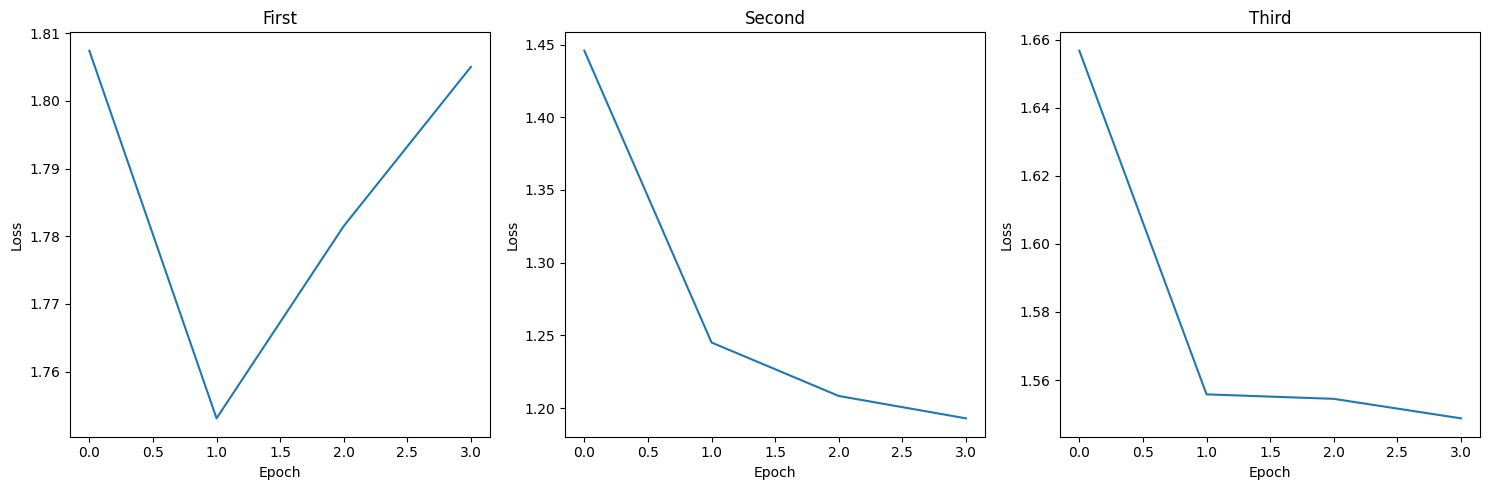

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(losses_1)
axes[0].set_title('First')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(losses_2)
axes[1].set_title('Second')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[2].plot(losses_3)
axes[2].set_title('Third')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

---

# ДОМАШНЕЕ ЗАДАНИЕ (дедлайн: 28 февраля, 23.59)

**Задача:** обучить модель с разными гиперпараметрами

1. Набор A: hidden_size=64, num_layers=1, learning_rate=0.01

2. Набор B: hidden_size=256, num_layers=2, learning_rate=0.001

3. Набор C: любой произвольный набор параметров hidden_size, num_layers, learning_rate, отличный от предложенных

Сравните:

- Скорость сходимости (график loss)
- Качество генерации (осмысленность текста)
- Время обучения

- У второй и третьей модели loss стабильно уменьшается, у первой уменьшается на первых двух эпохах, потом начинает расти. Наиболее быстро учится вторая модель, несмотря на наименьший learning_rate
- Генерации:
1. the company said wish will fear be parchasiane shargh six and and
2. the company said the respections with elrearly and higher in north
3. the company said lest to prices reverable in motth the stated the
Результаты генерации второй модели лучше, чем первой и третьей, в нем появляется всего одно несуществующее слово, оно почти связное
- Время обучения:
1. 313 сек = 5.22 мин
2. 1083 сек = 18.05 мин - обучение самое долгое (большой hidden_size)
3. 391 сек = 6.52 мин

### **ВОПРОСЫ ДЛЯ РЕФЛЕКСИИ**

1.  Какие ключевые отличия вы заметили в подготовке данных для числового ряда (синусоида) и текста?

2.  Какой опыт работы с PyTorch (например, отладка, подбор параметров) оказался самым полезным?

1. Для подготовки текстовых данных необходимо их преобразовывать в числовой формат, а потом результат в формат текста. При работе с числовыми данными этого делать не нужно.
2. Мне наиболее полезным показалась отладка кода и приведение его к минимально рабочему состоянию, это выглядит сложнее и потребовало больше времени, чем работа с параметрами